In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

In [2]:
### All global variables that would be passed as arguments in a python script
input_folders = [
    "/home/nils/Downloads/WindowManagementBM_1739708247",
    "/home/nils/Downloads/WindowManagementBM_1739708263",
    "/home/nils/Downloads/WindowManagementBM_1739708279",
    "/home/nils/Downloads/WindowManagementBM_1739708295",
    "/home/nils/Downloads/WindowManagementBM_1739708312",
    "/home/nils/Downloads/WindowManagementBM_1739708328"
]
output_folder = "/home/nils/Downloads/output_plots"
statistics_csv_name = "all_statistics.csv"
worker_statistics_csv_name = "combined_worker_statistics.csv"
pipeline_txt_name = "pipelines.txt"
cache_hits_misses_name = "cache_hits_and_misses.txt"
benchmark_config_file = "benchmark_config.yaml"
statistics_csv_path = os.path.join(output_folder, statistics_csv_name)


# Remove the output_folder and then create it again
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)


# Set the seaborn style
sns.set(style="whitegrid")

In [3]:
# Converts a large number to a string 
def format_si_units(number):
    # Define SI unit prefixes
    si_prefixes = ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y']

    # Handle zero as a special case
    if number == 0:
        return "0"

    # Determine the sign of the number
    sign = ''
    if number < 0:
        sign = '-'
        number = -number

    # Determine the order of magnitude
    order_of_magnitude = 0
    while number >= 1000 and order_of_magnitude < len(si_prefixes) - 1:
        number /= 1000.0
        order_of_magnitude += 1

    # Format the number to one decimal place and append the SI prefix
    formatted_number = f"{number:.3f}{si_prefixes[order_of_magnitude]}"

    # Add the sign back to the formatted number
    return sign + formatted_number


# Converting pipelines.txt to a dict of pipeline id to a title
def extract_pipeline_data(input_path):
    with open(input_path, 'r') as input_file:
        input_text = input_file.read()

    pipeline_dict = {}
    # Split the input text by the delimiter
    pipeline_sections = input_text.split("############################################")
    physical_pattern = re.compile(r"\bPhysical\w+")

    for section in pipeline_sections:
        # Find the pipeline ID in the section
        pipeline_match = re.search(r"Pipeline:\s*(\d+)", section)
        if pipeline_match:
            pipeline_id = int(pipeline_match.group(1))
            if pipeline_id not in pipeline_dict:
                pipeline_dict[pipeline_id] = []
            
            # Find all words starting with 'Physical' in the section
            physical_matches = physical_pattern.findall(section)
            cleaned_matches = [match.replace("Physical", "").replace("Operator", "").replace("Stream", "") for match in physical_matches]
            pipeline_dict[pipeline_id].extend(cleaned_matches)
    
    # Concatenate multiple values with "_"
    return {key: "_".join(values) for key, values in pipeline_dict.items()}

# Converting a cache hits and misses file to two dictionaries
def parse_lines_to_dataframe(file):
    with open(file, 'r') as input_file:
        lines = input_file.readlines()
        
    # Initialize dictionaries to hold the hits and misses data
    hits_data = {}
    misses_data = {}

    # Regular expression to extract information
    pattern = re.compile(r'Hits: (\d+) Misses: (\d+) for worker thread (\d+)(?: and join build side (\w+))?')

    for line in lines:
        match = pattern.search(line)
        if match:
            hits, misses, thread_id, build_side = match.groups()
            # Determine the column name
            if build_side:
                column_name = f'worker_{thread_id}_{build_side}'
            else:
                column_name = f'worker_{thread_id}'

            # Store the hits and misses in the dictionaries with prefixes
            hits_column_name = f'hits_{column_name}'
            misses_column_name = f'misses_{column_name}'

            if hits_column_name not in hits_data:
                hits_data[hits_column_name] = []
                misses_data[misses_column_name] = []

            hits_data[hits_column_name] = (int(hits))
            misses_data[misses_column_name] = (int(misses))

    # Adding a total hits and misses column
    hits_data["hits_total"] = sum(hit for hit in hits_data.values())
    misses_data["misses_total"] = sum(miss for miss in misses_data.values())
    
    return (hits_data, misses_data)

In [4]:
# Gathering all cache statistic files across all folders
def load_cache_statistics():
    cache_statistic_files = [(input_folder_name, os.path.join(input_folder_name, f)) for input_folder_name in input_folders for f in os.listdir(input_folder_name) if cache_hits_misses_name in f]
    cache_stats_combined_df = pd.DataFrame()
    no_cache_stats_files = len(cache_stats_combined_df)
    cnt_rows = 0
    for idx, [input_folder, cache_stat_file] in enumerate(cache_statistic_files):
        # Reading the benchmark configs and the hits and misses
        with open(os.path.join(input_folder, benchmark_config_file), 'r') as file:
            benchmark_config_yaml = yaml.safe_load(file)
    
        (hits_dict, misses_dict) = parse_lines_to_dataframe(cache_stat_file)
        
        # Combine the dictionaries
        combined_dict = {**hits_dict, **misses_dict, **benchmark_config_yaml.copy()}
        new_row_df = pd.DataFrame([combined_dict])
        cache_stats_combined_df = pd.concat([cache_stats_combined_df, new_row_df], ignore_index=True)

    cache_stats_combined_df = cache_stats_combined_df.apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')
    cache_stats_combined_df["slice_cache"] = cache_stats_combined_df["slice_cache_type"].astype(str) + "_" + cache_stats_combined_df["numberOfEntriesSliceCache"].astype(str)

    return cache_stats_combined_df
    
# Converting query engine statistics to statistics csv
def load_worker_statistics():
    pattern_task_details = (r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+).*?"
           r"Task (?P<task_id>\d+) for Pipeline (?P<pipeline>\d+).*?"
           r"(?P<action>Started|Completed)(?:\. Number of Tuples: (?P<num_tuples>\d+))?")
    
    # Gathering all statistic files across all folders
    statistic_files = [(input_folder_name, os.path.join(input_folder_name, f)) for input_folder_name in input_folders for f in os.listdir(input_folder_name) if worker_statistics_csv_name in f]
    combined_df = pd.DataFrame()
    no_statistics_files = len(statistic_files)
    cnt_rows = 0
    for idx, [input_folder, stat_file] in enumerate(statistic_files):
        print(f"Reading {stat_file} [{idx+1}/{no_statistics_files}]")
        df = pd.read_csv(stat_file)
    
        # Normalize all timestamps to the minimal start timestamp of any task
        df['start_time'] = pd.to_datetime(df['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
        df['end_time'] = pd.to_datetime(df['end_time'], format="%Y-%m-%d %H:%M:%S.%f")
        min_start_time = df['start_time'].min()
        df['start_time_normalized'] = df['start_time'] - min_start_time
        df['end_time_normalized'] = df['end_time'] - min_start_time
    
        # Sorting the dataframe
        df = df.sort_values(by='task_id').reset_index(drop=True)
        
        # Adding this dataframe to the global one
        cnt_rows += len(df)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    
    
    # Writing the combined dataframe to a csv file
    #combined_df.to_csv(statistics_csv_path, index=False)
    print(f"Done with combining all query engine statistics to {statistics_csv_path}!")
    return combined_df

In [5]:
# Reading the combined data into dataframe named df and printing a little summary of the data frame
df = load_worker_statistics()
    
# General info
print("### DataFrame Summary ###\n")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
print("Columns and Data Types:")
print(df.dtypes, "\n")

# Number of unique values per column
print("Number of Unique Values per Column:")
print(df.nunique(), "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum(), "\n")

# Descriptive statistics for numeric columns
print("Descriptive Statistics (Numeric Columns):")
print(df.describe().T, "\n")

# Display a sample of rows
print("Sample Rows:")
display(df.head(5))

Reading /home/nils/Downloads/WindowManagementBM_1739708247/combined_worker_statistics.csv [1/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708263/combined_worker_statistics.csv [2/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708279/combined_worker_statistics.csv [3/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708295/combined_worker_statistics.csv [4/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708312/combined_worker_statistics.csv [5/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708328/combined_worker_statistics.csv [6/6]
Done with combining all query engine statistics to /home/nils/Downloads/output_plots/all_statistics.csv!
### DataFrame Summary ###

Shape: 564380 rows, 22 columns

Columns and Data Types:
buffer_size_in_bytes                             int64
buffers_in_global_buffer_manager                 int64
buffers_in_source_local_buffer_pool              int64
buffers_per_worker                               int64
lock_slice_cache

,buffer_size_in_bytes,buffers_in_global_buffer_manager,buffers_in_source_local_buffer_pool,buffers_per_worker,lock_slice_cache,nautilus_backend,numberOfEntriesSliceCache,number_of_worker_threads,query,slice_cache_type,...,timestamp_increment,task_id,start_time,end_time,duration,num_tuples,throughput,pipeline_id,start_time_normalized,end_time_normalized
0,8196,1000000,1000,12800,False,COMPILER,1,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,...,1,0,2025-02-16 12:17:31.383457312,2025-02-16 12:17:31.383488345,0.000031,256,8.258065e+06,4,0 days 00:00:00,0 days 00:00:00.000031033
1,8196,1000000,1000,12800,False,COMPILER,1,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,...,1,1,2025-02-16 12:17:31.383490506,2025-02-16 12:17:31.383496313,0.000005,256,5.120000e+07,4,0 days 00:00:00.000033194,0 days 00:00:00.000039001
2,8196,1000000,1000,12800,False,COMPILER,1,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,...,1,2,2025-02-16 12:17:31.383497097,2025-02-16 12:17:31.383499563,0.000002,54,2.700000e+07,4,0 days 00:00:00.000039785,0 days 00:00:00.000042251
3,8196,1000000,1000,12800,False,COMPILER,1,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,...,1,3,2025-02-16 12:17:31.383500206,2025-02-16 12:17:31.383526355,0.000026,256,9.846154e+06,3,0 days 00:00:00.000042894,0 days 00:00:00.000069043
4,8196,1000000,1000,12800,False,COMPILER,1,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,...,1,4,2025-02-16 12:17:31.383527403,2025-02-16 12:17:31.383528251,0.000000,256,-1.000000e+00,3,0 days 00:00:00.000070091,0 days 00:00:00.000070939


Reading /home/nils/Downloads/WindowManagementBM_1739708247/combined_worker_statistics.csv [1/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708263/combined_worker_statistics.csv [2/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708279/combined_worker_statistics.csv [3/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708295/combined_worker_statistics.csv [4/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708312/combined_worker_statistics.csv [5/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708328/combined_worker_statistics.csv [6/6]
Done with combining all query engine statistics to /home/nils/Downloads/output_plots/all_statistics.csv!


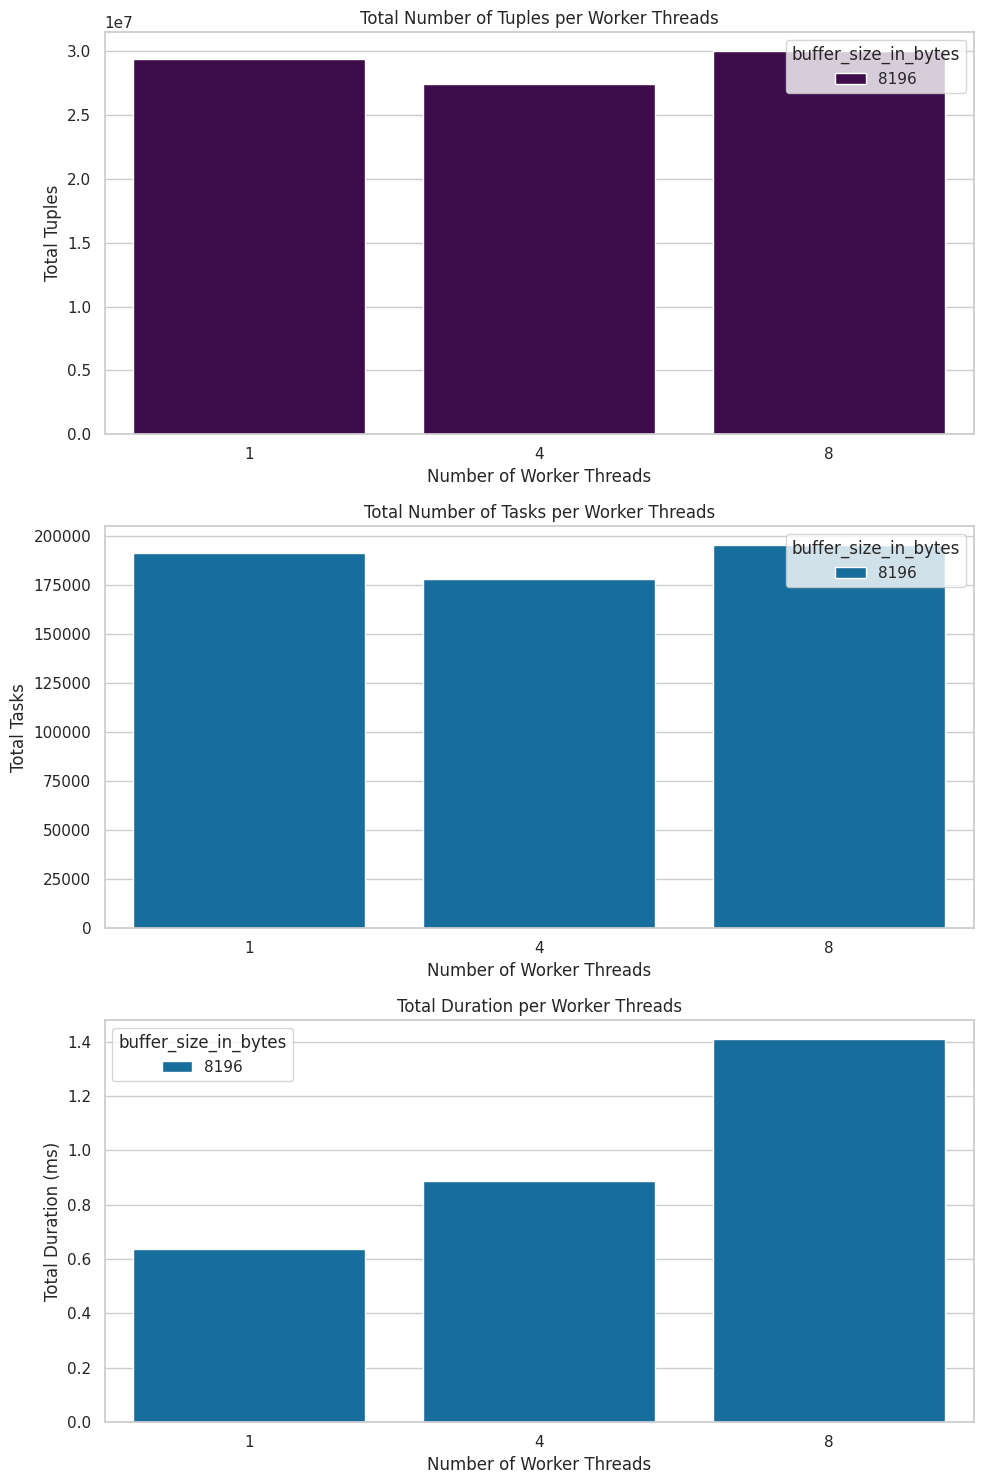

In [6]:
# Plotting the total no. tuples, no. tasks, total duration per no. worker threads
df = load_worker_statistics()
# Aggregate the data by number_of_worker_threads
aggregated_data = df.groupby(["number_of_worker_threads", "buffer_size_in_bytes"]).agg(
    total_tuples=('num_tuples', 'sum'),
    total_tasks=('task_id', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot total number of tuples
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tuples",
    palette="viridis",
    hue="buffer_size_in_bytes",
    ax=axes[0]
)
axes[0].set_title("Total Number of Tuples per Worker Threads")
axes[0].set_xlabel("Number of Worker Threads")
axes[0].set_ylabel("Total Tuples")

# Plot total number of tasks
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tasks",
    palette="colorblind",
    hue="buffer_size_in_bytes",
    ax=axes[1]
)
axes[1].set_title("Total Number of Tasks per Worker Threads")
axes[1].set_xlabel("Number of Worker Threads")
axes[1].set_ylabel("Total Tasks")

# Plot total duration
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_duration",
    palette="colorblind",
    hue="buffer_size_in_bytes",
    ax=axes[2]
)
axes[2].set_title("Total Duration per Worker Threads")
axes[2].set_xlabel("Number of Worker Threads")
axes[2].set_ylabel("Total Duration (ms)")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close(fig)


Reading /home/nils/Downloads/WindowManagementBM_1739708247/combined_worker_statistics.csv [1/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708263/combined_worker_statistics.csv [2/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708279/combined_worker_statistics.csv [3/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708295/combined_worker_statistics.csv [4/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708312/combined_worker_statistics.csv [5/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708328/combined_worker_statistics.csv [6/6]
Done with combining all query engine statistics to /home/nils/Downloads/output_plots/all_statistics.csv!
                                   num_tuples  duration     throughput
interval number_of_worker_threads                                     
0        1                                  0  0.000000            NaN
         4                                  0  0.000000            NaN
         8                         

/tmp/ipykernel_96594/2526759963.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
/tmp/ipykernel_96594/2526759963.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()


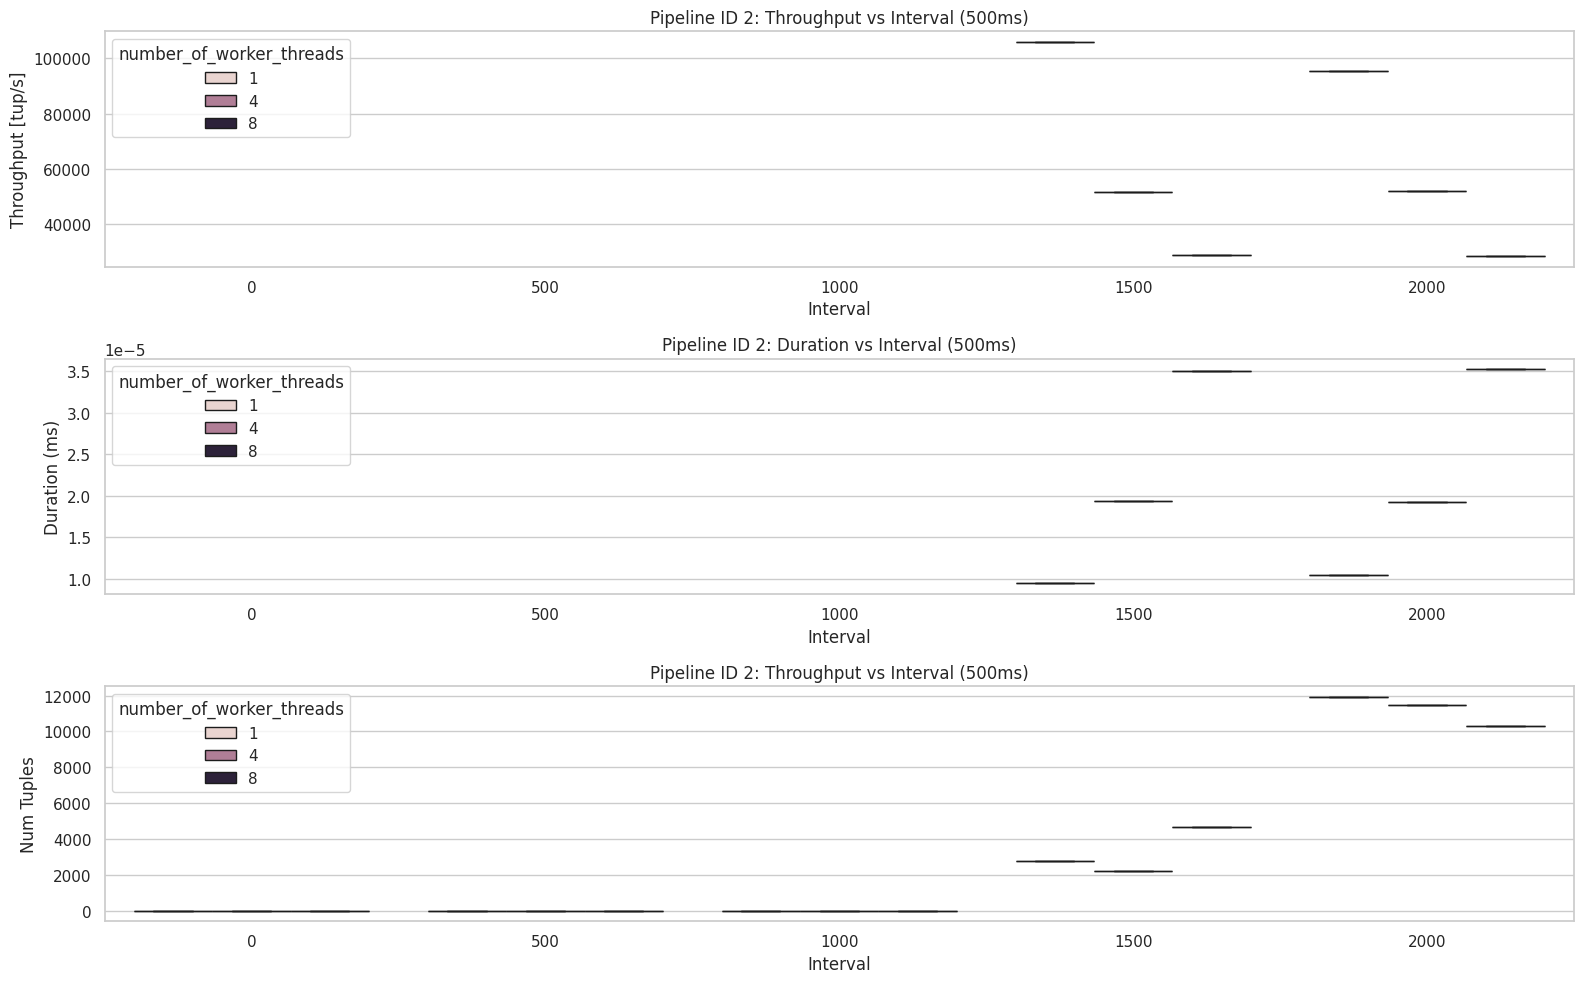

/tmp/ipykernel_96594/2526759963.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
/tmp/ipykernel_96594/2526759963.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()


                                   num_tuples  duration    throughput
interval number_of_worker_threads                                    
0        1                            3559981  0.001792  1.986597e+09
         4                            3399274  0.002896  1.173782e+09
         8                            3658884  0.011831  3.092624e+08
500      1                            3795396  0.000933  4.067949e+09
         4                            3457231  0.001768  1.955447e+09
         8                            3823149  0.011451  3.338703e+08
1000     1                            3782669  0.000750  5.043559e+09
         4                            3458294  0.001816  1.904347e+09
         8                            3828112  0.013505  2.834589e+08
1500     1                            3555703  0.000637  5.581951e+09
         4                            3365222  0.001557  2.161350e+09
         8                            3658497  0.014524  2.518932e+08
2000     1          

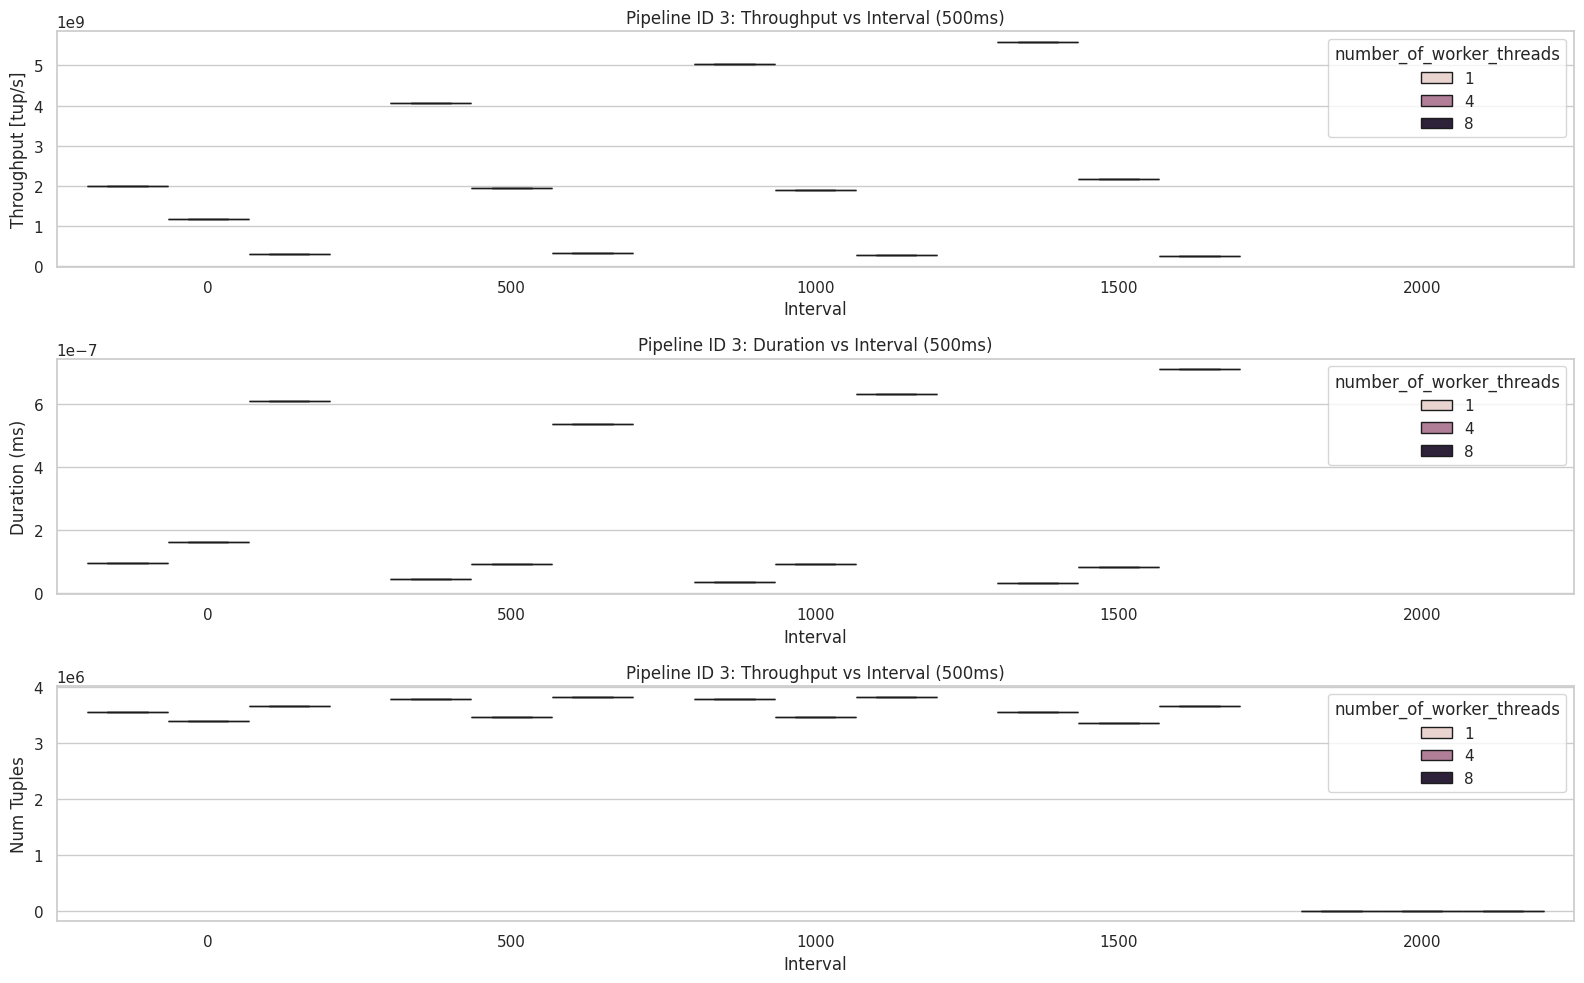

/tmp/ipykernel_96594/2526759963.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
/tmp/ipykernel_96594/2526759963.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()


                                   num_tuples  duration    throughput
interval number_of_worker_threads                                    
0        1                            3559981  0.132373  2.689356e+07
         4                            3399530  0.165971  2.048267e+07
         8                            3658884  0.180623  2.025702e+07
500      1                            3795396  0.126441  3.001713e+07
         4                            3456975  0.146054  2.366916e+07
         8                            3823149  0.200417  1.907597e+07
1000     1                            3782669  0.112000  3.377383e+07
         4                            3458294  0.146797  2.355834e+07
         8                            3828368  0.203579  1.880532e+07
1500     1                            3555703  0.103394  3.438984e+07
         4                            3365548  0.139756  2.408160e+07
         8                            3659702  0.202896  1.803733e+07
2000     1          

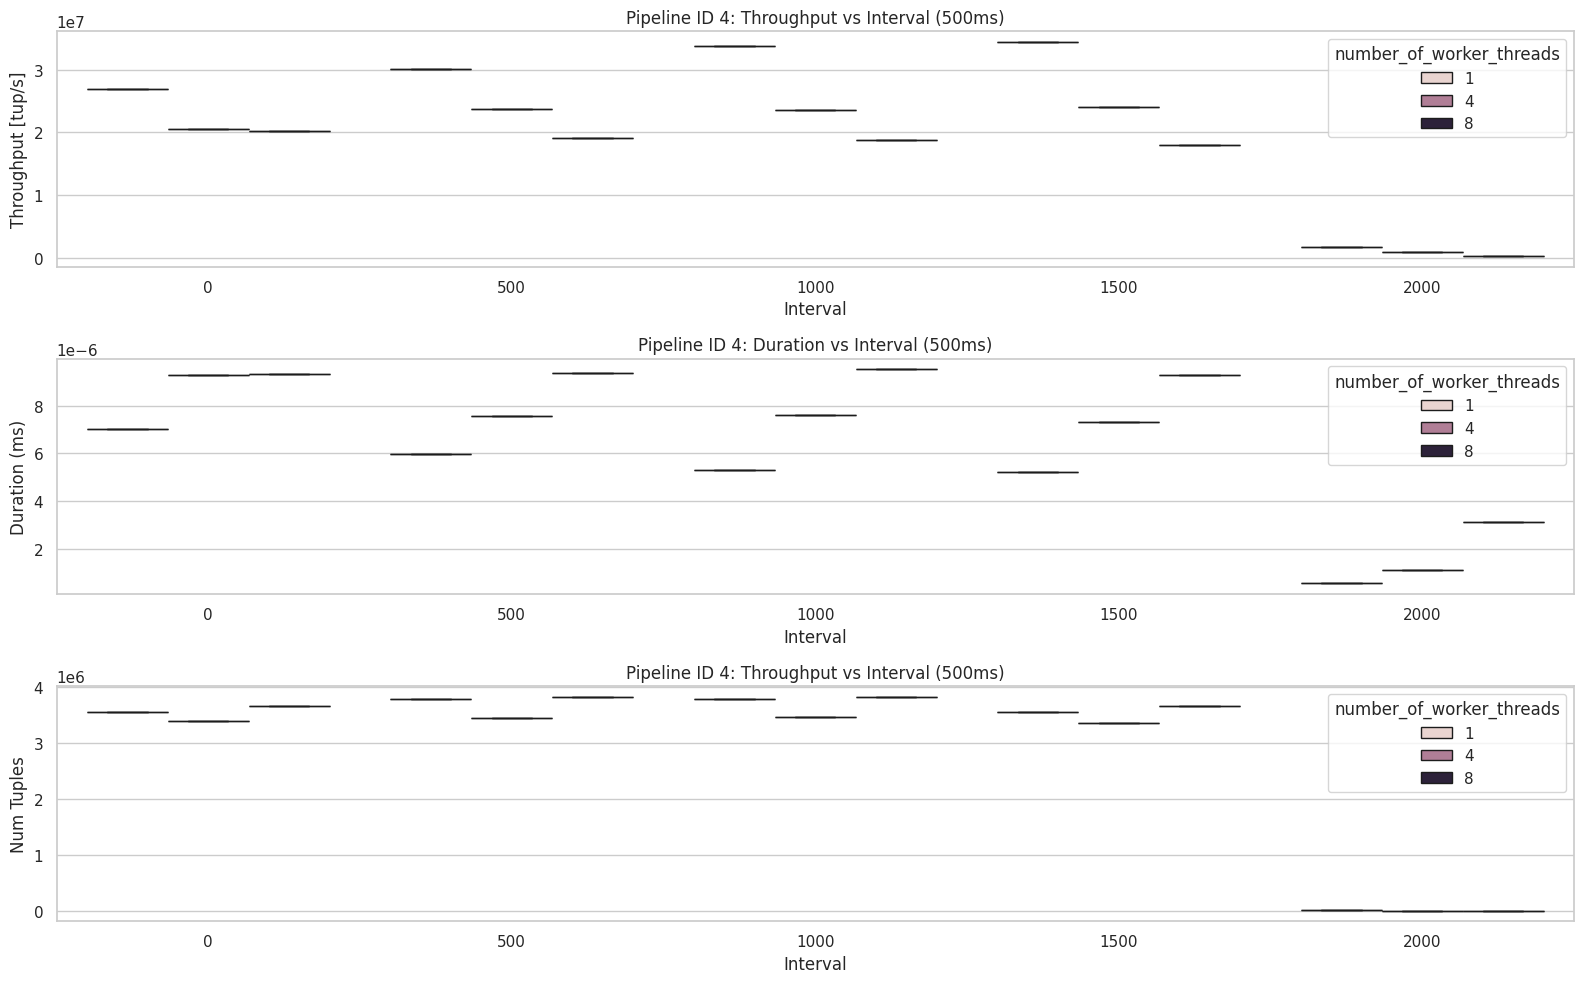

In [7]:
# Plotting the throughput and duration for each pipeline in intervals
# Only do this for buffer_size_in_bytes == 8196
df = load_worker_statistics()
df = df[df['buffer_size_in_bytes'] == 8196]

# Normalize the timestamps to timedelta and milliseconds
df['start_time_normalized'] = pd.to_timedelta(df['start_time_normalized'])
df['start_time_normalized_ms'] = df['start_time_normalized'].dt.total_seconds() * 1000
df['end_time_normalized'] = pd.to_timedelta(df['end_time_normalized'])

# Create intervals
interval_size_in_ms = 500
intervals = pd.cut(df['start_time_normalized_ms'], bins=range(0, int(df['start_time_normalized_ms'].max()) + interval_size_in_ms, interval_size_in_ms), right=False)
df['interval'] = intervals
df['interval'] = df['interval'].apply(lambda x: x.left)

# Group by pipeline_id and create a plot for each group
interesting_pipeline_ids = df["pipeline_id"].unique()
df = df[df['pipeline_id'].isin(interesting_pipeline_ids)]
for pipeline_id, group in df.groupby("pipeline_id"):
    # Select only the necessary columns for computation
    group = group[['interval', 'number_of_worker_threads', 'throughput', 'duration', 'num_tuples']]
    
    sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
        'num_tuples': 'sum',
        'duration': 'sum',
    })
    # Calculate throughput as sum(num_tuples) / sum(duration)
    sum_group['throughput'] = sum_group['num_tuples'] / sum_group['duration']

    # Calculate the average duration
    avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()

    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Plot throughput vs interval
    sns.boxplot(
        data=sum_group,
        x="interval",
        y="throughput",
        hue="number_of_worker_threads",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Throughput [tup/s]")

    # Plot duration vs interval
    sns.boxplot(
        data=avg_group,
        x="interval",
        y="duration",
        hue="number_of_worker_threads",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Interval ({interval_size_in_ms}ms)")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Duration (ms)")

    # Plot no. tuples vs interval
    sns.boxplot(
        data=sum_group,
        x="interval",
        y="num_tuples",
        hue="number_of_worker_threads",
        ax=axes[2]
    )
    axes[2].set_title(f"Pipeline ID {pipeline_id}: No. Tuples vs Interval ({interval_size_in_ms}ms)")
    axes[2].set_xlabel("Interval")
    axes[2].set_ylabel("Num Tuples")

    # Adjust layout and save the figure
    plt.tight_layout()
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}_intervals_{interval_size_in_ms}ms.png")
    #plt.savefig(figure_path)
    plt.show()
    plt.close(fig)  # Close the figure to free memory



Reading /home/nils/Downloads/WindowManagementBM_1739708247/combined_worker_statistics.csv [1/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708263/combined_worker_statistics.csv [2/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708279/combined_worker_statistics.csv [3/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708295/combined_worker_statistics.csv [4/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708312/combined_worker_statistics.csv [5/6]
Reading /home/nils/Downloads/WindowManagementBM_1739708328/combined_worker_statistics.csv [6/6]
Done with combining all query engine statistics to /home/nils/Downloads/output_plots/all_statistics.csv!


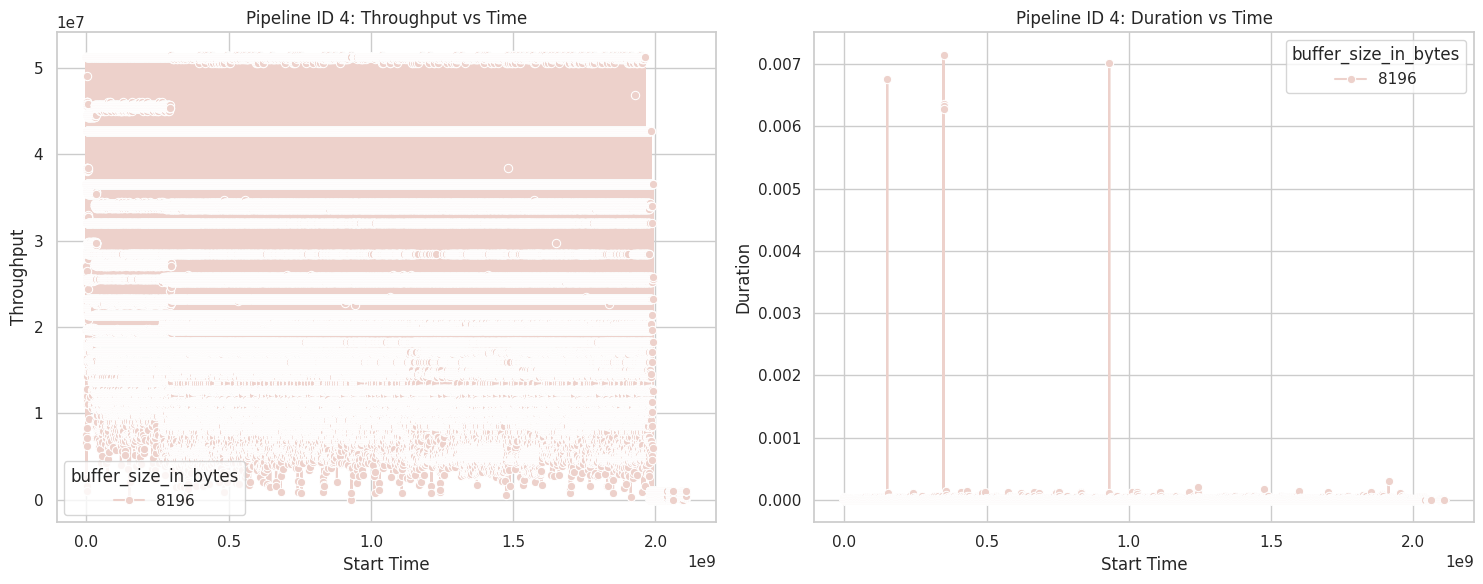

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a862195f8e0>>
Traceback (most recent call last):
  File "/home/nils/jupyter_notebook/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

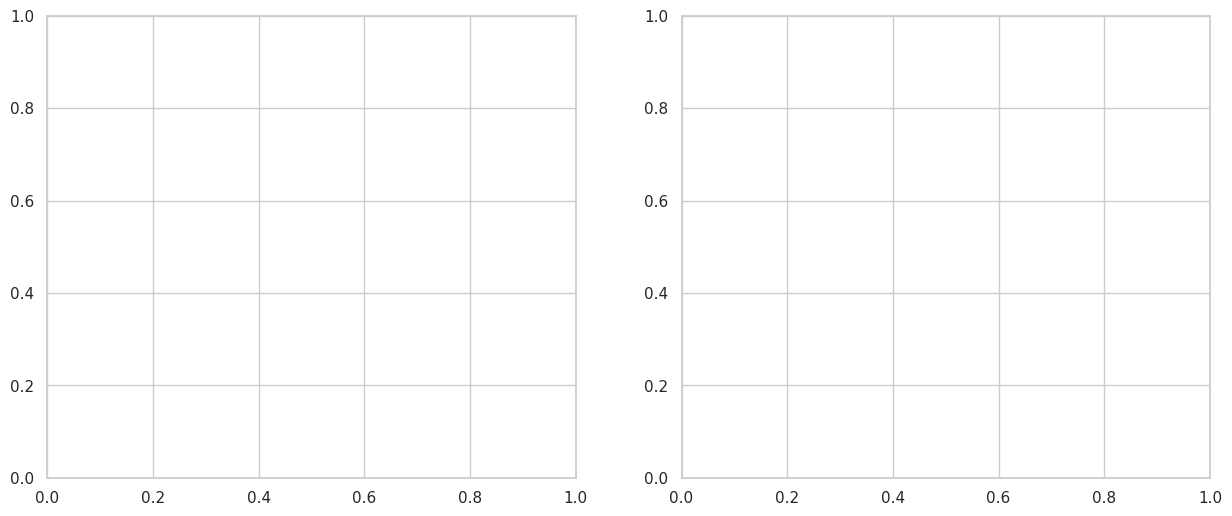

In [8]:
#Plotting duration and throughput as a lineplot over the start_time_normalized
# Unique pipeline IDs
df = load_worker_statistics()
unique_pipeline_ids = df['pipeline_id'].unique()

# Generate one plot per pipeline
for pipeline_id in unique_pipeline_ids:
    # Filter data for the current pipeline_id
    pipeline_data = df[df['pipeline_id'] == pipeline_id]
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot throughput
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='throughput',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Time")
    axes[0].set_xlabel("Start Time")
    axes[0].set_ylabel("Throughput")
    
    # Plot duration
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='duration',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Time")
    axes[1].set_xlabel("Start Time")
    axes[1].set_ylabel("Duration")
    
    # Adjust layout for readability
    plt.tight_layout()
    
    # Save the figure
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}.png")
    #plt.savefig(figure_path)
    plt.show()
    plt.close(fig)  # Close the figure to save memory

/tmp/ipykernel_96594/1476699748.py:19: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  cache_stats_combined_df = cache_stats_combined_df.apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')


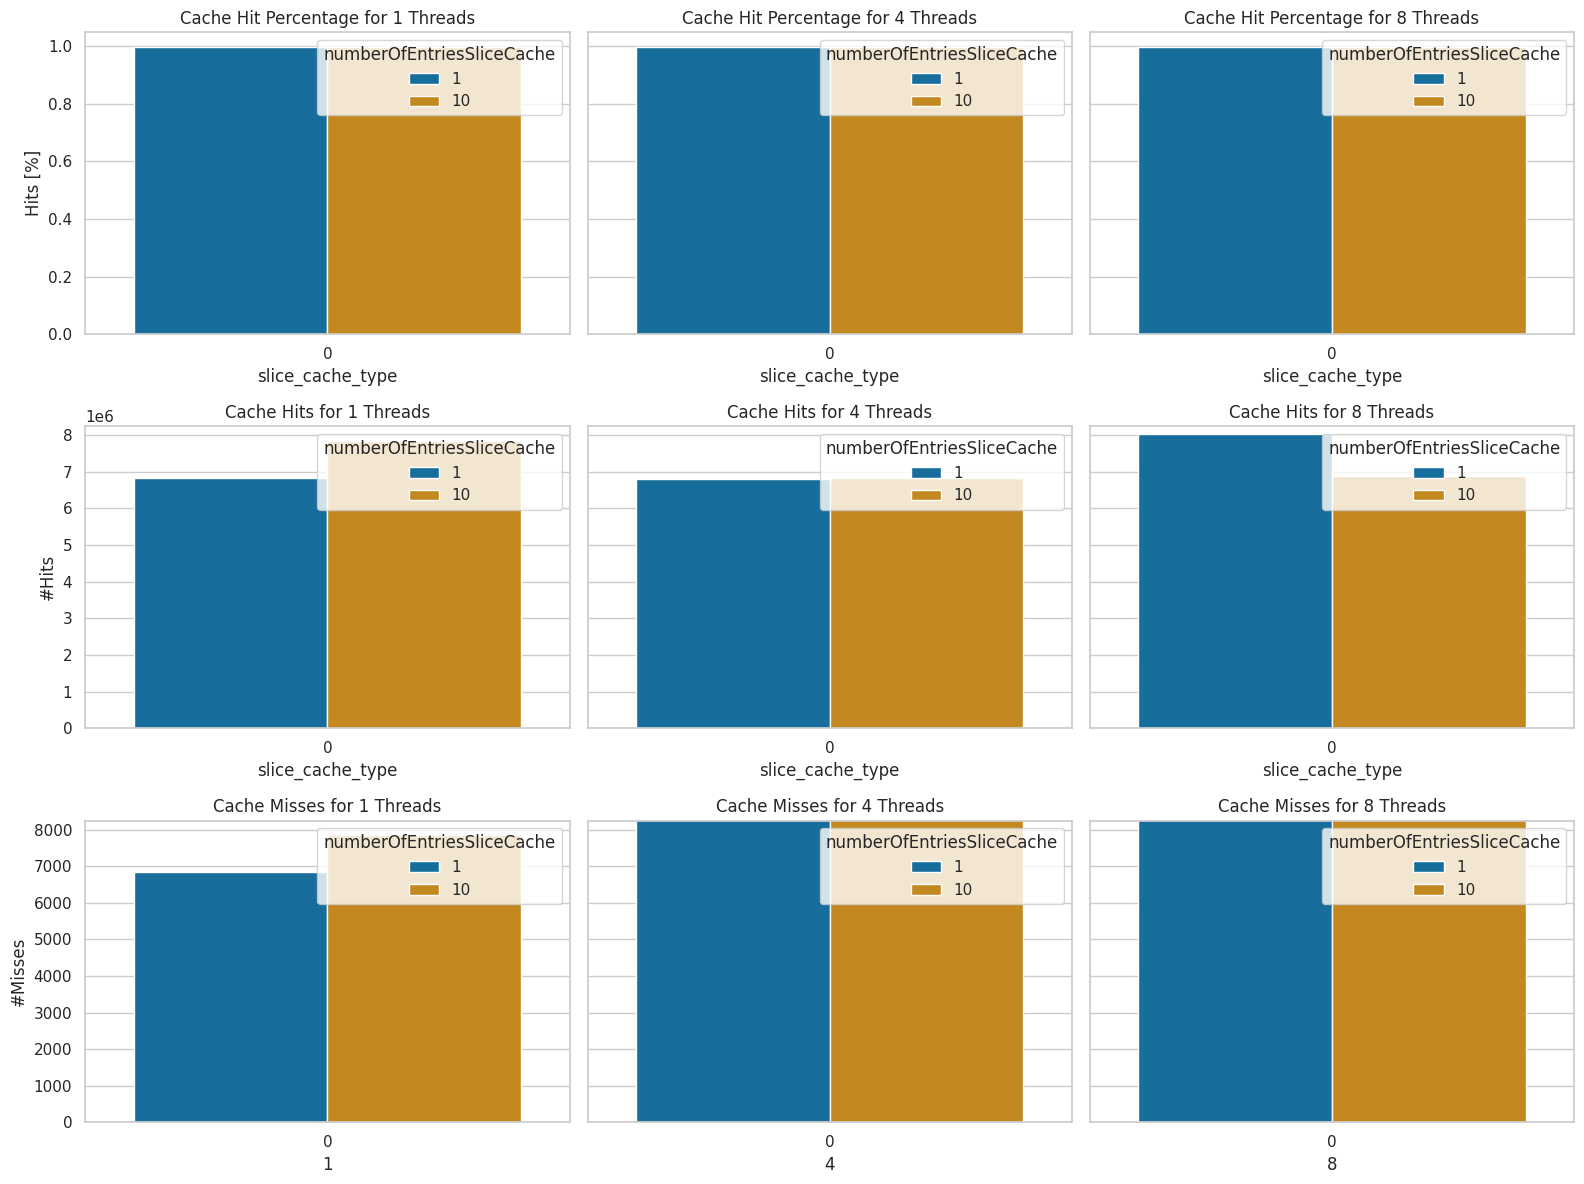

In [11]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache_type"
hue = "numberOfEntriesSliceCache"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])

# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(3, n_params, figsize=(16, 12), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]

    ax = axes[0][idx]
    sns.barplot(x=x_param, y=y_params[0], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Hit Percentage for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"Hits [%]")
    ax.set_ylim(bottom=0)

    ax = axes[1][idx]
    sns.barplot(x=x_param, y=y_params[1], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Hits for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"#Hits")
    ax.set_ylim(bottom=0)

    ax = axes[2][idx]
    sns.barplot(x=x_param, y=y_params[2], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Misses for {param} Threads")
    ax.set_xlabel(param)
    ax.set_ylabel(f"#Misses")
    #ax.set_yscale('log')
    ax.set_ylim(bottom=0)


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

/tmp/ipykernel_96594/1476699748.py:19: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  cache_stats_combined_df = cache_stats_combined_df.apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')


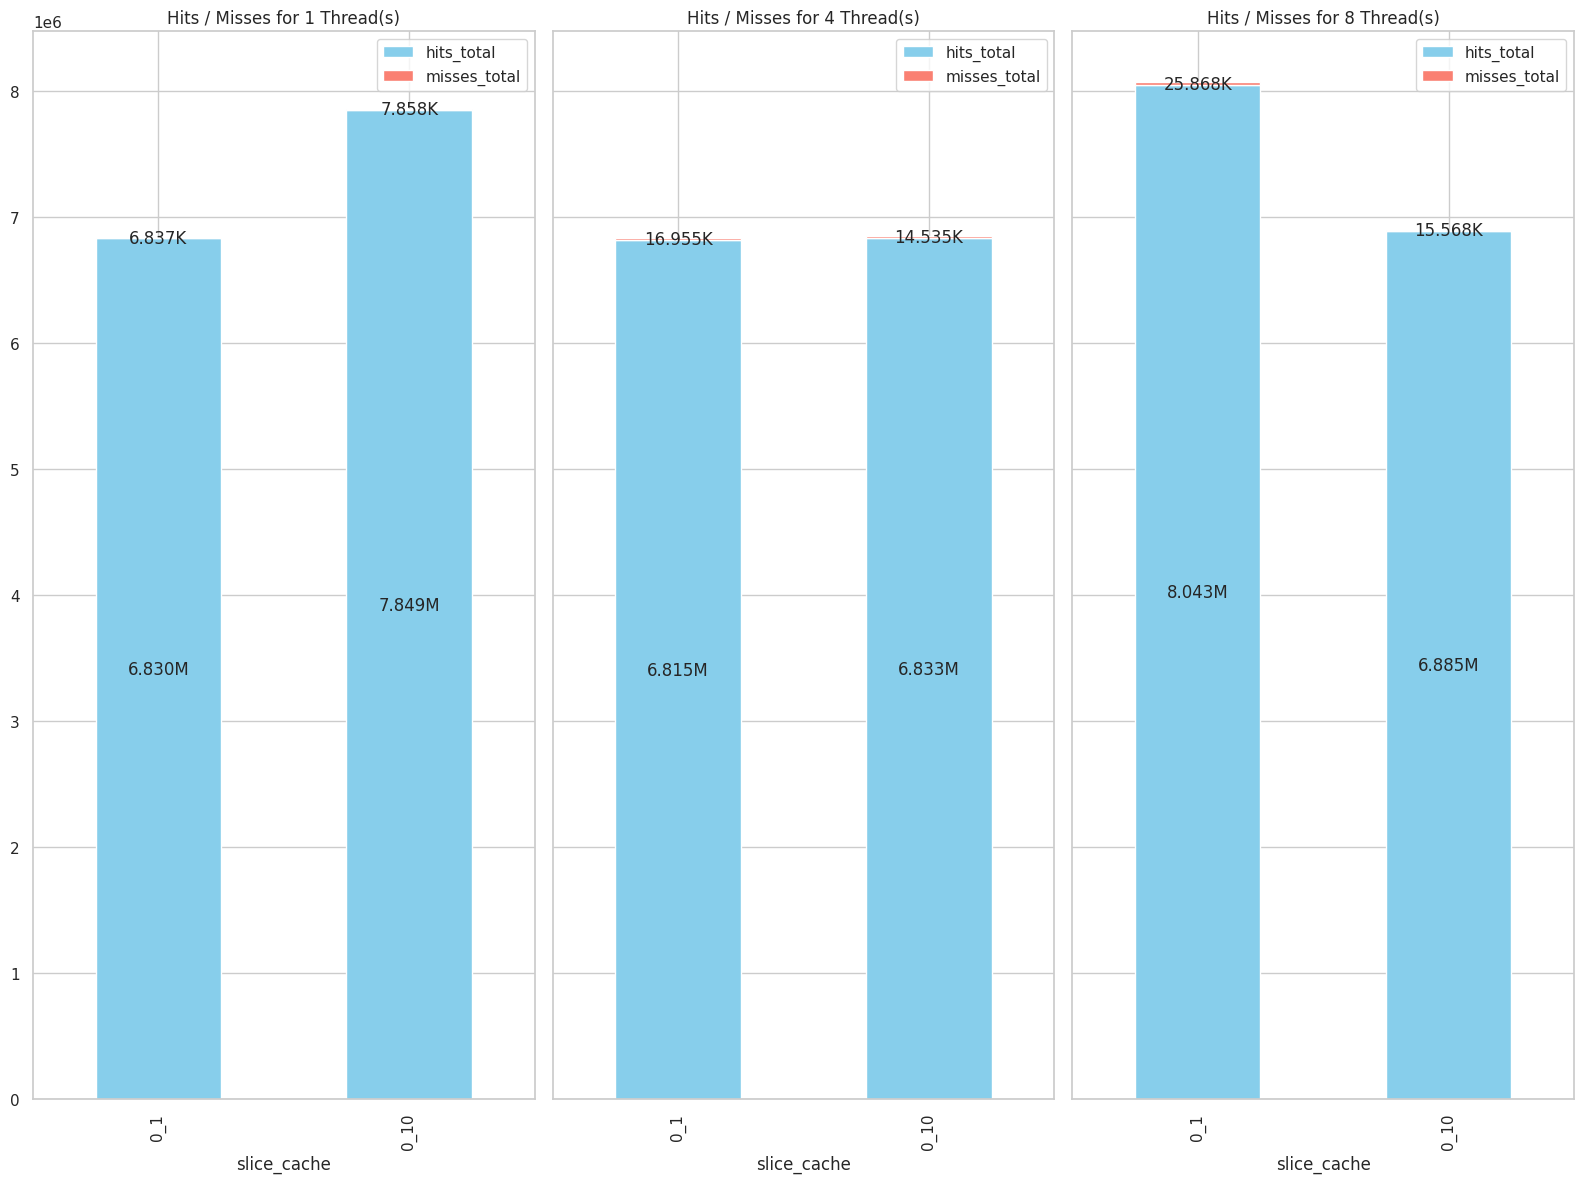

In [10]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache"
hue = "numberOfEntriesSliceCache"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])



# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 12), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]
    plot_data = subset[["hits_total", "misses_total"]]
    plot_data.set_index(subset[x_param], inplace=True)
    ax = axes[0][idx]
    
    plot_data.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon']) #, logy=True)
    ax.set_title(f"Hits / Misses for {param} Thread(s)")
    #ax.set_ylim(bottom=0.1)
    
    
    # Annotate the bars with hits and misses values
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        height_str = format_si_units(height)
        ax.text(x + width / 2, y + height / 2, f'{height_str}', horizontalalignment='center', verticalalignment='center')


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()